# Spam Vs Ham Classifier

This notebook corresponds to excercise #4 of the book, we will use the Apache Spam assasing corpus https://spamassassin.apache.org/old/publiccorpus/.

I'm going to work with:
* 20021010_spam.tar.bz2 (Contains emails flagged as spam)
* 20021010_easy_ham.tar.bz2 (Contains easily recognizable ham emails)
* 20021010_hard_ham.tar.bz2 (Contains ham emails but can be mistaken with spam)

## Data exploration
Let's see the content of these folders.


In [1]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_URL = "http://spamassassin.apache.org/old/publiccorpus/"
HAM_URL = DOWNLOAD_URL + "20021010_easy_ham.tar.bz2"
SPAM_URL = DOWNLOAD_URL + "20021010_spam.tar.bz2"
DATASETS_PATH = os.path.join('./', 'spamham')

def fetch_data(files, datasets_path=DATASETS_PATH):
    if not files:
        raise ValueError("You must provide the files to download")
    
    if type(files) != tuple:
        if type(files) == list and type(files[0]) != tuple:
            raise ValueError("The files must be a tuple or list of tuples e.g.: ('filename', 'url') or [('filename', 'url')]")
                
    if not os.path.isdir(datasets_path):
        os.makedirs(datasets_path)
        
    for filename, url in files:
        path = os.path.join(datasets_path, filename)
        if not os.path.isfile(path):
            urllib.request.urlretrieve(url, path)
        tar_bz2_file = tarfile.open(path)
        tar_bz2_file.extractall(path=DATASETS_PATH)
        tar_bz2_file.close()

In [2]:
files = [
    ('ham.tar.bz2', HAM_URL),
    ('spam.tar.bz2', SPAM_URL)
]

fetch_data(files)

In [3]:
HAM_DIR = os.path.join(DATASETS_PATH, 'easy_ham')
SPAM_DIR = os.path.join(DATASETS_PATH, 'spam')

ham_filenames = [name for name in sorted(os.listdir(HAM_DIR)) if len(name) > 20]
spam_filenames = [name for name in sorted(os.listdir(SPAM_DIR)) if len(name) > 20]

In [4]:
print("Ham samples: ", len(ham_filenames))
print("Spam samples: ", len(spam_filenames))

Ham samples:  2551
Spam samples:  501


In [5]:
import email
import email.policy

def load_email(is_spam, filename, path=DATASETS_PATH):
    directory = 'spam' if is_spam else 'easy_ham'
    with open(os.path.join(DATASETS_PATH, directory, filename), 'rb') as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)

In [6]:
ham_emails = [load_email(False, name) for name in ham_filenames]
spam_emails = [load_email(True, name) for name in spam_filenames]

### This is a ham email

In [7]:
print(ham_emails[0].get_content().strip())

Date:        Wed, 21 Aug 2002 10:54:46 -0500
    From:        Chris Garrigues <cwg-dated-1030377287.06fa6d@DeepEddy.Com>
    Message-ID:  <1029945287.4797.TMDA@deepeddy.vircio.com>


  | I can't reproduce this error.

For me it is very repeatable... (like every time, without fail).

This is the debug log of the pick happening ...

18:19:03 Pick_It {exec pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace} {4852-4852 -sequence mercury}
18:19:03 exec pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace 4852-4852 -sequence mercury
18:19:04 Ftoc_PickMsgs {{1 hit}}
18:19:04 Marking 1 hits
18:19:04 tkerror: syntax error in expression "int ...

Note, if I run the pick command by hand ...

delta$ pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace  4852-4852 -sequence mercury
1 hit

That's where the "1 hit" comes from (obviously).  The version of nmh I'm
using is ...

delta$ pick -version
pick -- nmh-1.0.4 [compiled on fuchsia.cs.mu.OZ.AU at Sun Mar 17 14:55:56 

### Now this is a spam

In [8]:
print(spam_emails[6].get_content().strip())

A POWERHOUSE GIFTING PROGRAM You Don't Want To Miss! 
 
  GET IN WITH THE FOUNDERS! 
The MAJOR PLAYERS are on This ONE
For ONCE be where the PlayerS are
This is YOUR Private Invitation

EXPERTS ARE CALLING THIS THE FASTEST WAY 
TO HUGE CASH FLOW EVER CONCEIVED
Leverage $1,000 into $50,000 Over and Over Again

THE QUESTION HERE IS:
YOU EITHER WANT TO BE WEALTHY 
OR YOU DON'T!!!
WHICH ONE ARE YOU?
I am tossing you a financial lifeline and for your sake I 
Hope you GRAB onto it and hold on tight For the Ride of youR life!

Testimonials

Hear what average people are doing their first few days:
�We've received 8,000 in 1 day and we are doing that over and over again!' Q.S. in AL
 �I'm a single mother in FL and I've received 12,000 in the last 4 days.� D. S. in FL
�I was not sure about this when I sent off my $1,000 pledge, but I got back $2,000 the very next day!� L.L. in KY
�I didn't have the money, so I found myself a partner to work this with. We have received $4,000 over the last 2 days

### Email structures
Emails can have different structures, some might contain attachments, and attached emails that might also contain attachments. Let's decompose the email structures.

In [9]:
def get_email_structure(email):
    if isinstance(email, str):
        return email
    payload = email.get_payload()
    if isinstance(payload, list):
        return "multipart({})".format(", ".join([
            get_email_structure(sub_email) for sub_email in payload
        ]))
    else:
        return email.get_content_type()

In [10]:
from collections import Counter

def structures_counter(emails):
    structures = Counter()
    for email in emails:
        structure = get_email_structure(email)
        structures[structure] += 1
    return structures

In [11]:
ham_structure_count = structures_counter(ham_emails).most_common()
ham_structure_count

[('text/plain', 2453),
 ('multipart(text/plain, application/pgp-signature)', 72),
 ('multipart(text/plain, text/html)', 8),
 ('multipart(text/plain, text/plain)', 4),
 ('multipart(text/plain)', 3),
 ('multipart(text/plain, application/octet-stream)', 2),
 ('multipart(text/plain, text/enriched)', 1),
 ('multipart(text/plain, application/ms-tnef, text/plain)', 1),
 ('multipart(multipart(text/plain, text/plain, text/plain), application/pgp-signature)',
  1),
 ('multipart(text/plain, video/mng)', 1),
 ('multipart(text/plain, multipart(text/plain))', 1),
 ('multipart(text/plain, application/x-pkcs7-signature)', 1),
 ('multipart(text/plain, multipart(text/plain, text/plain), text/rfc822-headers)',
  1),
 ('multipart(text/plain, multipart(text/plain, text/plain), multipart(multipart(text/plain, application/x-pkcs7-signature)))',
  1),
 ('multipart(text/plain, application/x-java-applet)', 1)]

In [12]:
spam_structure_count = structures_counter(spam_emails).most_common()
spam_structure_count

[('text/plain', 222),
 ('text/html', 181),
 ('multipart(text/plain, text/html)', 45),
 ('multipart(text/html)', 19),
 ('multipart(text/plain)', 19),
 ('multipart(multipart(text/html))', 5),
 ('multipart(text/plain, image/jpeg)', 3),
 ('multipart(text/html, application/octet-stream)', 2),
 ('multipart(text/plain, application/octet-stream)', 1),
 ('multipart(text/html, text/plain)', 1),
 ('multipart(multipart(text/html), application/octet-stream, image/jpeg)', 1),
 ('multipart(multipart(text/plain, text/html), image/gif)', 1),
 ('multipart/alternative', 1)]

It seems the proportion of text/plan vs text/html is significantly different. Spam emails tend to be more on the text/html side. Also, ham emails tend to use pgp-signature while none of the spam emails uses one. This might be a useful attribute.

In [13]:
import numpy as np

ham_structures = np.array([[pair[0], pair[1]] for pair in ham_structure_count])
spam_structures = np.array([[pair[0], pair[1]] for pair in spam_structure_count])

In [14]:
import matplotlib.pyplot as plt

# Omit the first class as the proportion won't allow to see the rest
ham_struct_types = ham_structures[1:,0]
ham_struct_counts = ham_structures[1:,1].astype(np.int)

classes = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "L", "M", "N", "O"]
prop_iter = iter(plt.cm.tab20.colors)

plt.figure(figsize=(15, 8))
legends = []
for t, c, l in zip(classes, ham_struct_counts, ham_struct_types):
    bar = plt.bar(t, c, color=next(prop_iter), label=l)
    legends.append(bar)
plt.legend(handles=legends)
plt.show()

<Figure size 1500x800 with 1 Axes>

In the above plot, I have omitted the text/plain class as the amount surpasses significantly the others and mekes them hard to see. From this chart, we can observe that among ham, the most frequent class other than plain/text is the one that uses pgp-signature.

Now, let's observe what happens with the spam.

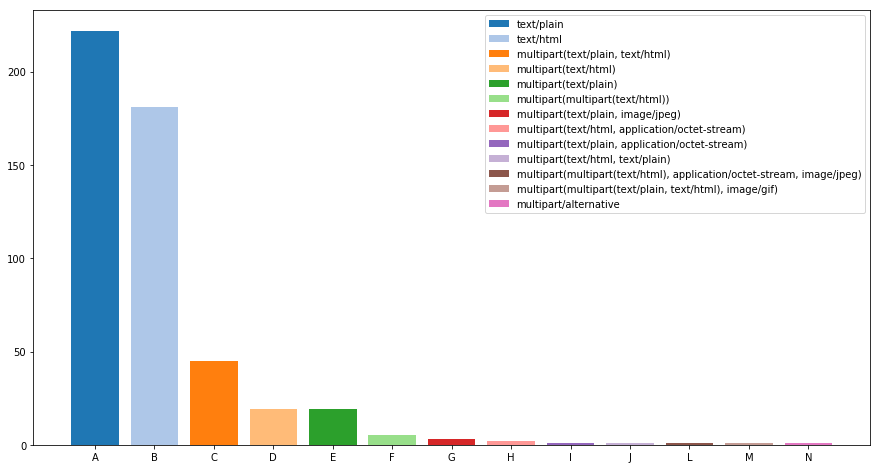

In [15]:
spam_struct_types = spam_structures[0:,0]
spam_struct_counts = spam_structures[0:,1].astype(np.int)

classes = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "L", "M", "N"]
prop_iter = iter(plt.cm.tab20.colors)

plt.figure(figsize=(15, 8))
legends = []
for t, c, l in zip(classes, spam_struct_counts, spam_struct_types):
    bar = plt.bar(t, c, color=next(prop_iter), label=l)
    legends.append(bar)
plt.legend(handles=legends)
plt.show()

On Spam, we observe that there is no signature type emails, the highest ones are text/plain and text/html.

### Email headers

In [16]:
for header, value in spam_emails[1].items():
    print(header, ":", value)

Return-Path : <12a1mailbot1@web.de>
Delivered-To : zzzz@localhost.example.com
Received : from localhost (localhost [127.0.0.1])	by phobos.labs.example.com (Postfix) with ESMTP id 136B943C32	for <zzzz@localhost>; Thu, 22 Aug 2002 08:17:21 -0400 (EDT)
Received : from mail.webnote.net [193.120.211.219]	by localhost with POP3 (fetchmail-5.9.0)	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 13:17:21 +0100 (IST)
Received : from dd_it7 ([210.97.77.167])	by webnote.net (8.9.3/8.9.3) with ESMTP id NAA04623	for <zzzz@example.com>; Thu, 22 Aug 2002 13:09:41 +0100
From : 12a1mailbot1@web.de
Received : from r-smtp.korea.com - 203.122.2.197 by dd_it7  with Microsoft SMTPSVC(5.5.1775.675.6);	 Sat, 24 Aug 2002 09:42:10 +0900
To : dcek1a1@netsgo.com
Subject : Life Insurance - Why Pay More?
Date : Wed, 21 Aug 2002 20:31:57 -1600
MIME-Version : 1.0
Message-ID : <0103c1042001882DD_IT7@dd_it7>
Content-Type : text/html; charset="iso-8859-1"
Content-Transfer-Encoding : quoted-printable


Probably, there is useful information here, like the sender, this kind of email, 'Life Insurance - Why Pay More?' looks suspicuous.

In [17]:
spam_emails[1]["Subject"]

'Life Insurance - Why Pay More?'

### Train/Test Split

In [18]:
import numpy as np
from sklearn.model_selection import train_test_split

X = np.array(ham_emails + spam_emails)
y = np.array([0] * len(ham_emails) + [1] * len(spam_emails))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Preprocessing
We would want to convert HTML emails into plain/text. The original author's solutions creates regex based parsers but suggest BeautifulSoup as an alternative. I'm going to use this library for the sake of learning!

Ref
* https://www.crummy.com/software/BeautifulSoup/bs4/doc/

In [19]:
#From X_train get all where the indexes has a y_train==1
html_spam_emails = [email for email in X_train[y_train==1] if get_email_structure(email) == "text/html"]
html_sample = html_spam_emails[0].get_content().strip()

This is a spam sample in HTML form

In [20]:
print(html_sample[:1000], '...')

<html>

<head>
<meta http-equiv="Content-Language" content="en-us">
<meta name="GENERATOR" content="Microsoft FrontPage 4.0">
<meta name="ProgId" content="FrontPage.Editor.Document">
<meta http-equiv="Content-Type" content="text/html; charset=windows-1252">
<title>Norton AD</title>
</head>

<body>

<table border="0" width="489" height="54" bgcolor="#FFFFFF">
  <tr>
    <td width="100%" height="48" bgcolor="#FFFFFF" align="center"><font face="Impact" color="#CC0000" size="3">Take
      Control of Your Computer With This Top-of-the-Line Software!</font></td>
  </tr>
</table>

<table border="5" cellspacing="3" width="489" cellpadding="3" bgcolor="#990033"  bordercolor="#FFFFFF" style="border-collapse: collapse" bordercolordark="#000000" height="567" bordercolorlight="#FFFF99">
  <tr>
    <td width="467" height="555" bordercolorlight="#FFFFFF" bordercolordark="#FFFF99">
      <table border="6" width="100%" height="86" bgcolor="#FFFF99" bordercolor="#FFFFFF">
        <tr>
          <td widt

Let's take a look at one of the HTML emails using the IPython display

In [21]:
import IPython
IPython.display.HTML(html_sample)

Take Control of Your Computer With This Top-of-the-Line Software!
Norton SystemWorks 2002 Software Suite -Professional Edition-
Includes Six - Yes 6! - Feature-Packed UtilitiesALL for 1 Special LOW Price of Only $29.99!
This Software Will: - Protect your computer from unwanted and hazardous viruses - Help secure your private & valuable information - Allow you to transfer files and send e-mails safely - Backup your ALL your data quick and easily - Improve your PC's performance w/superior integral diagnostics! - You'll NEVER have to take your PC to the repair shop AGAIN!
6 Feature-Packed Utilities 1 Great Price A $300+ Combined Retail Value YOURS for Only $29.99! < Price Includes FREE Shipping! >And For a Limited time Buy Any 2 of Our Products & Get 1 Free!
-> CLICK HERE to Order Yours NOW! <-


Now, the goal is strip down all the HTML tags and just stay with the text. The rules:

* All head tags must me removed
* All links, i.e., ```<a>``` tags, must be repladed with the word 'HYPERLINK'
* All HTML tags must be stripped, i.e., Remove all the ```<whathever/>```
* Remove all the HTML escape characters such as ```&gt;```, ```&nbsp;```

Fortunately, it seems that Beautiful Soup makes very easy to navigate all the HTML tree effortlessly, so this is just a matter of picking the information as needed.

In [68]:
from bs4 import BeautifulSoup
import re

def html_to_plain_text(email):
    soup = BeautifulSoup(email, 'html.parser')
    for link in soup.findAll('a'):
        link.replace_with(' HYPERLINK ' + link.getText())
    text = soup.getText().strip()
    #https://docs.python.org/3.5/library/re.html#re.sub
    text = re.sub(r'(\s*\n+)', '\n', text, flags=re.M | re.S) # r.M (multiline), r.S (dot matches all)
    return text

In [69]:
print(html_to_plain_text(html_sample))

Norton AD
Take
      Control of Your Computer With This Top-of-the-Line Software!
Norton
            SystemWorks 2002  Software Suite
            -Professional Edition-
Includes
            Six - Yes 6!
            - Feature-Packed UtilitiesALL for 1
            Special LOW
            Price of Only
            $29.99!
This
            Software Will: -
            Protect your computer from unwanted and  hazardous  viruses -
            Help secure your private & valuable information - Allow
            you to transfer files and send e-mails  safely -
            Backup your ALL your data quick and easily - Improve your
            PC's performance w/superior
            integral diagnostics! - You'll NEVER have to take your
            PC to the repair shop AGAIN!
6
            Feature-Packed Utilities
            1
            Great Price
            A $300+
            Combined Retail Value
YOURS  for
            Only $29.99!
<
            Price Includes FREE
Shipping! >And
        

Now, a function that takes an email and returns the text regardless of the input type/structure

In [71]:
def email_to_text(email):
    html = None
    for part in email.walk():
        ctype = part.get_content_type()
        if not ctype in ('text/plain', 'text/html'):
            continue
        try:
            content = part.get_content()
        except: # in case of encoding issues
            content = str(part.get_payload())
        if ctype == 'text/plain':
            return content
        else:
            html = content
    if html:
        return html_to_plain_text(html)

In [74]:
print(email_to_text(html_spam_emails[0])[:100], '...')

Norton AD
Take
      Control of Your Computer With This Top-of-the-Line Software!
Norton
            ...


Works good!

Now, we need to do some NLP, for this we will need to install ```nltk```

In [75]:
from nltk import PorterStemmer

stemmer = PorterStemmer()
for word in ("Computations", "Computation", "Computing", "Computed", "Compute", "Compulsive"):
    print(word, '=>', stemmer.stem(word))

Computations => comput
Computation => comput
Computing => comput
Computed => comput
Compute => comput
Compulsive => compuls


Now let's detect the urls. For this we will use ```urlextract``` which will simple extract from a given text, anything that is a url.

In [76]:
from urlextract import URLExtract

url_extractor = URLExtract()
print(url_extractor.find_urls("Will it detect github.com and https://youtu.be/7Pq-S557XQU?t=3m32s"))

['github.com', 'https://youtu.be/7Pq-S557XQU?t=3m32s']
